# Supervised, Multi-Class Classification of Scam Reports: Experiment 2 (Classification with Class Balanced with Text Augmentation)

The objective of this Python notebook is to train three deep learning models, namely the RNN, LSTM and Bi-LSTM on the **augmented** text data corresponding to the top six scam types, both with and without the GloVe pre-train word embeddings. This notebook will also evaluate the trained models on the test set.

## Import the necessary libraries

In [2]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from collections import Counter
import tensorflow as tf
from keras.models import Sequential, Model
from keras import layers, models
from keras.layers import Input, Embedding, LSTM, SimpleRNN, Dense, Concatenate, Bidirectional, Dropout, GRU
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import nltk
import random
import re
import pickle
import timeit

%pprint

C:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.

Pretty printing has been turned OFF


Using TensorFlow backend.


## Mount drive and change to correct directory

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# cd /content/drive/My Drive/Dissertation

## Define functions

In [5]:
def data_top_n(data, n):
    
    """This function takes a scam dataframe and returns records corresponding to the top n categories."""
    
    count_df = data[['scam_type','preprocessed_text']].groupby('scam_type').aggregate({'preprocessed_text':'count'}).reset_index().sort_values('preprocessed_text',ascending=False)
    top_n_scam_types = list(count_df.nlargest(n, 'preprocessed_text').scam_type)
    
    return data[data['scam_type'].isin(top_n_scam_types)]

In [6]:
def plot_confusion_matrix(cm,
                        classes,
                        path,
                        normalize=False,
                        title='Confusion Matrix',
                        cmap=plt.cm.Blues):
    
    """This function prints and plots a confusion matrix. 
    Normalised confusion matrix can be applied by setting `normalize=True'."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion Matrix with Normalised Values' 
    else:
        title = 'Confusion Matrix with Absolute Values'
    
    plt.figure(figsize=(10, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    
    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.savefig(path)
    plt.show()

In [7]:
def get_glove_vectors(filename="Data/glove.6B.200d.txt"):    
    
    """This function gets all GloVe word embeddings from a specified pre-trained model."""
    
    glove_vector_dict = {}
    with open(filename, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = values[1:]
            glove_vector_dict[word] = np.asarray(coefs, dtype='float32')
            
    return glove_vector_dict

In [8]:
def filter_glove(vocabulary_dict, glove_dict, embedding_dim=300):
    
    """This function creates a matrix to store the GloVe word embeddings based on a dictionary of vocabulary."""
    

    embedding_matrix = np.zeros((len(vocabulary_dict)+1, embedding_dim))
    hits = 0
    misses = 0
    
    for word, i in vocabulary_dict.items():
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            # words not found in the glove_dict will be all-zeros
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
            
    print("Converted %d words (%d misses)" % (hits, misses))        
    return embedding_matrix, hits, misses


In [9]:
def read_csv(path):
    
    """This function reads a CSV file from a specified filepath, while preserving the data types of each variable.
    Source: https://stackoverflow.com/questions/50047237/how-to-preserve-dtypes-of-dataframes-when-using-to-csv/50051542#50051542"""
    
    # Read types first line of csv
    dtypes = {key:value for (key,value) in pd.read_csv(path, nrows=1).iloc[0].to_dict().items() if 'date' not in value}

    parse_dates = [key for (key,value) in pd.read_csv(path, 
                   nrows=1).iloc[0].to_dict().items() if 'date' in value]
    
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, parse_dates=parse_dates, skiprows=[1])

In [10]:
def k_fold_cv(X_train, Y_train, k=5, model_name="RNN", filedir="Models/Scam_Classifier_1/"):

    """This function performs k-fold cross-validation give a particular model and saves the model at a specified file path."""
    
    print("\nPerforming a " + str(k) + "-fold cross-validation for " + model_name + " model")
    
    start = timeit.default_timer()
    
    # define k-fold cross validation test 
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds = list(kfold.split(X_train, Y_train))

    cvscores = []
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\nFold', j+1, "...\n")
        X_train_cv = X_train[train_idx]
        Y_train_cv = to_categorical([list(Y_train)[i] for i in tuple(train_idx)])
        X_test_cv = X_train[test_idx]
        Y_test_cv = to_categorical([list(Y_train)[i] for i in tuple(test_idx)])

        prefix = str(model_name)
        fold = "-fold-" + str(j+1)
        model_func = "create_" + model_name + "_model()"
        model = eval(model_func)
        checkpoint_path = filedir + "best-" + prefix + fold + ".h5"

        # Define early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, period=1)

        # Train the model
        model.fit(X_train_cv, Y_train_cv, epochs=30, batch_size=16, callbacks=[es, mc], verbose=1, validation_data = (X_test_cv, Y_test_cv))

        # Load best model and evaluate
        best_model = load_model(checkpoint_path)
        _, acc = best_model.evaluate(X_test_cv, Y_test_cv, batch_size=16, verbose=0)
        cvscores.append(acc*100)

    exec_time = timeit.default_timer() - start
    print("\nAverage Validation Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    
    print("Total Training Time (secs):", round(exec_time, 4))

    return cvscores, exec_time

In [11]:
def k_fold_cv_glove(X_train, Y_train, k=5, model_name="RNN", filedir="Models/Scam_Classifier_1/"):

    """This function performs k-fold cross-validation give a particular model with GloVe embeddings and saves the model at a specified file path."""

    print("\nPerforming a " + str(k) + "-fold cross-validation for " + model_name + " model")
    
    start = timeit.default_timer()
    
    # define k-fold cross validation test 
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds = list(kfold.split(X_train, Y_train))

    cvscores = []
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\nFold', j+1, "...\n")
        X_train_cv = X_train[train_idx]
        Y_train_cv = to_categorical([list(Y_train)[i] for i in tuple(train_idx)])
        X_test_cv = X_train[test_idx]
        Y_test_cv = to_categorical([list(Y_train)[i] for i in tuple(test_idx)])

        prefix = str(model_name)
        fold = "-fold-" + str(j+1)
        model_func = "create_" + model_name + "_model_glove()"
        model = eval(model_func)
        checkpoint_path = filedir + "best-" + prefix + fold + ".h5"

        # Define early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, period=1)

        # Train the model
        model.fit(X_train_cv, Y_train_cv, epochs=30, batch_size=16, callbacks=[es, mc], verbose=1, validation_data = (X_test_cv, Y_test_cv))

        # Load best model and evaluate
        best_model = load_model(checkpoint_path)
        _, acc = best_model.evaluate(X_test_cv, Y_test_cv, batch_size=16, verbose=0)
        cvscores.append(acc*100)

    exec_time = timeit.default_timer() - start
    print("\nAverage Validation Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    
    print("Total Training Time (secs):", round(exec_time, 4))

    return cvscores, exec_time

In [12]:
def create_RNN_model():

    """This function defines the architecture of a RNN model without GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with RNN")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(SimpleRNN(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [13]:
def create_LSTM_model():
    
    """This function defines the architecture of a LSTM model without GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with LSTM")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [14]:
def create_BiLSTM_model():

    """This function defines the architecture of a BiLSTM model without GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with BiLSTM")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [15]:
def create_RNN_model_glove():
    
    """This function defines the architecture of a RNN model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with RNN and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(SimpleRNN(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [16]:
def create_LSTM_model_glove():
    
    """This function defines the architecture of a LSTM model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with LSTM and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [17]:
def create_BiLSTM_model_glove():
    
    """This function defines the architecture of a BiLSTM model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with BiLSTM and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

## Prepare the data

In [18]:
# Import dataset with augmented data
data = pd.read_csv("Data/scam_data_4_augmented_top_6_400.csv")[['preprocessed_text', 'lemmatised', 'len_preprocessed_text', 'len_lemmatised', 'scam_type']]

# Convert scam type from category to string data type
data.scam_type = data.scam_type.astype('str')

# Sanity check
data.scam_type.value_counts()

Online Purchase Scam     400
Investment Scam          400
Home/Room Rental Scam    400
Credit-for-Sex Scam      400
Impersonation Scam       400
Internet Love Scam       400
Name: scam_type, dtype: int64

In [19]:
# Convert scam types into numbers
data.scam_type = data.scam_type.astype('category') 
data['scam_type_ids'] = data.scam_type.cat.codes

# Sanity check
data.scam_type_ids.unique()

array([2, 5, 3, 4, 1, 0], dtype=int8)

## Without pre-trained GloVe word embeddings

### Preparing training data

In [21]:
X = data.lemmatised
y = data.scam_type_ids
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_true = X_test
Y_true = Y_test

num_words = 8000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print("\n==> vocab_size: ", vocab_size)

# Set maximum length as the 80th percentile of the length of text in the dataset
maxlen = int(data.len_lemmatised.quantile(0.80))
print("==> maxlen: ", maxlen)

num_classes = len(data.scam_type.unique())
embedding_dim = 300
print("==> embedding_dim: ", embedding_dim)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Save the tokenizer
with open('Tokenizer/scam_classifier_augmented_text_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


==> vocab_size:  6992
==> maxlen:  66
==> embedding_dim:  300


### Visualise the models

#### RNN 

In [23]:
model = create_RNN_model()
model.summary()

Model: "Scam Classifier with RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 66, 300)           2097600   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               54912     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 2,153,286
Trainable params: 2,153,286
Non-trainable params: 0
_________________________________________________________________


#### LSTM

In [24]:
model = create_LSTM_model()
model.summary()

Model: "Scam Classifier with LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 66, 300)           2097600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 2,318,022
Trainable params: 2,318,022
Non-trainable params: 0
_________________________________________________________________


#### BiLSTM

In [25]:
model = create_BiLSTM_model()
model.summary()

Model: "Scam Classifier with BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 66, 300)           2097600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 2,538,438
Trainable params: 2,538,438
Non-trainable params: 0
_________________________________________________________________


### Training the models with 5-fold cross-validation

In [18]:
model_dict = {1: "RNN", 2: "LSTM", 3: "BiLSTM"}
acc_scores = []
training_time = []

for i, m in model_dict.items():
    model_name = model_dict.get(i)
    acc, time = k_fold_cv(X_train, Y_train, k=5, model_name=model_name, filedir="Models/Scam_Classifier_Augmented_Text/")
    acc_scores.append(acc)
    training_time.append(time)

j = len(acc_scores[0])   

# Initialise an empty dataframe
df = pd.DataFrame()
for i in range(j):
    fold = [scores[i] for scores in acc_scores]
    df2 = pd.DataFrame({str(i+1):fold})
    df = pd.concat([df, df2], axis=1)
df3 = pd.DataFrame({"time": training_time})    
df = pd.concat([df, df3], axis=1)
df = df.set_index(pd.Series(["RNN", "LSTM", "BiLSTM"]))
print("End of Experiment")
df


==> vocab_size:  7052
==> maxlen:  65
==> embedding_dim:  300

Performing a 5-fold cross-validation for RNN model

Fold 1 ...



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1536 samples, validate on 384 samples
Epoch 1/30
1536/1536 [==============================] - 9s 6ms/step - loss: 1.8463 - accuracy: 0.1719 - val_loss: 1.7904 - val_accuracy: 0.1693

Epoch 00001: val_loss improved from inf to 1.79041, saving model to Models/Scam_Classifier_Augmented_Text/best-RNN-fold-1.h5
Epoch 2/30
1536/1536 [==============================] - 8s 5ms/step - loss: 1.6863 - accuracy: 0.3184 - val_loss: 1.7407 - val_accuracy: 0.2214

Epoch 00002: val_loss improved from 1.79041 to 1.74074, saving model to Models/Scam_Classifier_Augmented_Text/best-RNN-fold-1.h5
Epoch 3/30
1536/1536 [==============================] - 7s 5ms/step - loss: 1.3602 - accuracy: 0.5469 - val_loss: 1.6867 - val_accuracy: 0.2786

Epoch 00003: val_loss improved from 1.74074 to 1.68670, saving model to Models/Scam_Classifier_Augmented_Text/best-RNN-fold-1.h5
Epoch 4/30
1536/1536 [==============================] - 8s 5ms/step - loss: 0.9235 - accuracy: 0.7181 - val_loss: 1.7951 - val_accuracy

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1536 samples, validate on 384 samples
Epoch 1/30
1536/1536 [==============================] - 14s 9ms/step - loss: 1.5767 - accuracy: 0.3301 - val_loss: 1.3283 - val_accuracy: 0.4583

Epoch 00001: val_loss improved from inf to 1.32830, saving model to Models/Scam_Classifier_Augmented_Text/best-LSTM-fold-1.h5
Epoch 2/30
1536/1536 [==============================] - 13s 9ms/step - loss: 1.0490 - accuracy: 0.6458 - val_loss: 1.0637 - val_accuracy: 0.5729

Epoch 00002: val_loss improved from 1.32830 to 1.06373, saving model to Models/Scam_Classifier_Augmented_Text/best-LSTM-fold-1.h5
Epoch 3/30
1536/1536 [==============================] - 13s 9ms/step - loss: 0.6679 - accuracy: 0.7604 - val_loss: 1.0431 - val_accuracy: 0.6354

Epoch 00003: val_loss improved from 1.06373 to 1.04305, saving model to Models/Scam_Classifier_Augmented_Text/best-LSTM-fold-1.h5
Epoch 4/30
1536/1536 [==============================] - 13s 9ms/step - loss: 0.5157 - accuracy: 0.8079 - val_loss: 1.0592 - val_a

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1536 samples, validate on 384 samples
Epoch 1/30
1536/1536 [==============================] - 28s 18ms/step - loss: 1.6255 - accuracy: 0.3112 - val_loss: 1.3464 - val_accuracy: 0.4896

Epoch 00001: val_loss improved from inf to 1.34637, saving model to Models/Scam_Classifier_Augmented_Text/best-BiLSTM-fold-1.h5
Epoch 2/30
1536/1536 [==============================] - 27s 17ms/step - loss: 1.0069 - accuracy: 0.6263 - val_loss: 1.0227 - val_accuracy: 0.6276

Epoch 00002: val_loss improved from 1.34637 to 1.02274, saving model to Models/Scam_Classifier_Augmented_Text/best-BiLSTM-fold-1.h5
Epoch 3/30
1536/1536 [==============================] - 27s 18ms/step - loss: 0.6748 - accuracy: 0.7546 - val_loss: 0.9334 - val_accuracy: 0.7031

Epoch 00003: val_loss improved from 1.02274 to 0.93339, saving model to Models/Scam_Classifier_Augmented_Text/best-BiLSTM-fold-1.h5
Epoch 4/30
1536/1536 [==============================] - 27s 17ms/step - loss: 0.4889 - accuracy: 0.8158 - val_loss: 0.99

,1,2,3,4,5,time
RNN,27.864584,30.468750,30.729166,31.510416,31.510416,517.373356
LSTM,63.541669,66.666669,59.635419,63.020831,62.500000,936.256114
BiLSTM,70.312500,65.104169,66.666669,66.927081,61.718750,1775.136190


### Save results as a CSV file

In [19]:
df.to_csv("Results/scam_classification_augmented_text_no_pretrained.csv")

## With pre-trained GloVe word embeddings (300D)

### Preparing the GloVe word embeddings

In [26]:
glove_embedding_dict = get_glove_vectors(filename="Data/glove.6B.300d.txt")
embedding_matrix, h, m = filter_glove(tokenizer.word_index, glove_embedding_dict, embedding_dim=300)
print(embedding_matrix.shape)

Converted 5990 words (1001 misses)
(6992, 300)


### Prepare training data

In [ ]:
X = data.lemmatised
y = data.scam_type_ids
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_true = X_test
Y_true = Y_test

num_words = 8000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print("\n==> vocab_size: ", vocab_size)

# Set maximum length as the 80th percentile of the length of text in the dataset
maxlen = int(data.len_lemmatised.quantile(0.80))
print("==> maxlen: ", maxlen)

num_classes = len(data.scam_type.unique())
embedding_dim = 300
print("==> embedding_dim: ", embedding_dim)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

### Visualise the models

#### RNN

In [27]:
model = create_RNN_model_glove()
model.summary()

Model: "Scam Classifier with RNN and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 66, 300)           2097600   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               54912     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 2,153,286
Trainable params: 55,686
Non-trainable params: 2,097,600
_________________________________________________________________


#### LSTM

In [28]:
model = create_LSTM_model_glove()
model.summary()

Model: "Scam Classifier with LSTM and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 66, 300)           2097600   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total params: 2,318,022
Trainable params: 220,422
Non-trainable params: 2,097,600
_________________________________________________________________


#### BiLSTM

In [29]:
model = create_BiLSTM_model_glove()
model.summary()

Model: "Scam Classifier with BiLSTM and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 66, 300)           2097600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 1542      
Total params: 2,538,438
Trainable params: 440,838
Non-trainable params: 2,097,600
_________________________________________________________________


### Training the models with 5-fold cross-validation

In [21]:
model_dict = {1: "RNN", 2: "LSTM", 3: "BiLSTM"}
acc_scores = []
training_time = []

for i, m in model_dict.items():
    model_name = model_dict.get(i)
    acc, time = k_fold_cv_glove(X_train, Y_train, k=5, model_name=model_name, filedir="Models/Scam_Classifier_Augmented_Text_Glove/")
    acc_scores.append(acc)
    training_time.append(time)

j = len(acc_scores[0])   

# Initialise an empty dataframe
df_glove = pd.DataFrame()
for i in range(j):
    fold = [scores[i] for scores in acc_scores]
    df2 = pd.DataFrame({str(i+1):fold})
    df_glove = pd.concat([df_glove, df2], axis=1)
df3 = pd.DataFrame({"time": training_time})    
df_glove = pd.concat([df_glove, df3], axis=1)
df_glove = df_glove.set_index(pd.Series(["RNN", "LSTM", "BiLSTM"]))
print("End of Experiment")
df_glove


==> vocab_size:  7052
==> maxlen:  65
==> embedding_dim:  300

Performing a 5-fold cross-validation for RNN model

Fold 1 ...

Train on 1536 samples, validate on 384 samples
Epoch 1/30
1536/1536 [==============================] - 6s 4ms/step - loss: 1.8763 - accuracy: 0.2168 - val_loss: 1.7364 - val_accuracy: 0.2786

Epoch 00001: val_loss improved from inf to 1.73642, saving model to Models/Scam_Classifier_Augmented_Text_Glove/best-RNN-fold-1.h5
Epoch 2/30
1536/1536 [==============================] - 5s 4ms/step - loss: 1.5082 - accuracy: 0.4010 - val_loss: 1.7667 - val_accuracy: 0.2656

Epoch 00002: val_loss did not improve from 1.73642
Epoch 3/30
1536/1536 [==============================] - 6s 4ms/step - loss: 1.3785 - accuracy: 0.4577 - val_loss: 1.7450 - val_accuracy: 0.3255

Epoch 00003: val_loss did not improve from 1.73642
Epoch 4/30
1536/1536 [==============================] - 6s 4ms/step - loss: 1.2266 - accuracy: 0.5247 - val_loss: 1.7521 - val_accuracy: 0.3672

Epoch 00004:

,1,2,3,4,5,time
RNN,27.864584,29.687500,33.072916,30.729166,34.114584,329.101006
LSTM,68.489581,67.187500,65.104169,69.270831,67.968750,998.682622
BiLSTM,67.708331,67.447919,64.583331,72.135419,67.968750,1819.427861


### Save results as a CSV file

In [23]:
df_glove.to_csv("Results/scam_classification_augmented_text_glove.csv")

## Evaluating on test set

### Prepare test data

In [39]:
# Import dataset
tdata = read_csv("Data/scam_data_4.csv")[['preprocessed_text', 'lemmatised', 'len_preprocessed_text', 'len_lemmatised', 'scam_type']]

# Convert scam type from category to string data type
tdata.scam_type = tdata.scam_type.astype('str')

# Extract records corresponding to top six scam types
tdata = data_top_n(data=tdata, n=6)

# Sanity check
tdata.scam_type.value_counts()

Impersonation Scam       1611
Online Purchase Scam      812
Internet Love Scam        707
Investment Scam           264
Home/Room Rental Scam     227
Credit-for-Sex Scam       197
Name: scam_type, dtype: int64

In [40]:
# Convert scam types into numbers
tdata.scam_type = tdata.scam_type.astype('category') 
tdata['scam_type_ids'] = tdata.scam_type.cat.codes

# Sanity check
tdata.scam_type_ids.unique()

array([2, 1, 3, 0, 5, 4], dtype=int8)

In [43]:
_, X_test, _, Y_test = train_test_split(tdata.lemmatised, tdata.scam_type_ids, stratify=tdata.scam_type_ids, test_size=0.20, random_state=42)
X_true = X_test
Y_true = Y_test
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

### Load the results

In [48]:
df2 = pd.read_csv("Results/scam_classification_augmented_text_no_pretrained.csv")
df2.columns = ['model', '1', '2', '3', '4', '5', 'time']
df2['mode'] = 2 # for text augmentation
df2['combi'] = 3
df2['glove'] = 'N'

In [49]:
df2g = pd.read_csv("Results/scam_classification_augmented_text_glove.csv")
df2g.columns = ['model', '1', '2', '3', '4', '5', 'time']
df2g['mode'] = 2 # for text augmentation
df2g['combi'] = 4
df2g['glove'] = 'Y'

In [50]:
results_df = pd.concat([df2, df2g], axis=0)
results_df['mean_acc'] = round(results_df.drop(columns=['model', 'time', 'mode', 'combi', 'glove']).mean(axis=1), 1)
results_df['time'] = round(results_df['time'])
results_df['fold_max'] = results_df[['1', '2', '3', '4', '5']].idxmax(axis=1)
results_df = results_df[['model',  'combi', 'mode', 'glove', 'fold_max','mean_acc', 'time']]
results_df

,model,combi,mode,glove,fold_max,mean_acc,time
0,RNN,3,2,N,5,27.3,712.0
1,LSTM,3,2,N,5,66.7,1557.0
2,BiLSTM,3,2,N,5,65.7,2825.0
0,RNN,4,2,Y,3,34.4,538.0
1,LSTM,4,2,Y,5,68.4,1644.0
2,BiLSTM,4,2,Y,5,67.2,2903.0


In [51]:
folder_list = ['Scam_Classifier_Augmented_Text', 'Scam_Classifier_Augmented_Text_Glove']

<START OF EVALUATION>

[Scam Classifier with Text Augmentation]

Loading best RNN model from --> Models/Scam_Classifier_Augmented_Text/best-RNN-fold-5.h5
Average Validation Accuracy: 27.3%
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Accuracy on Test Set:	67.1%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.37      0.41      0.39        39
Home/Room Rental Scam       0.49      0.60      0.54        45
   Impersonation Scam       0.91      0.84      0.87       322
   Internet Love Scam       0.55      0.61      0.58       142
      Investment Scam       0.40      0.68      0.50        53
 Online Purchase Scam       0.64      0.48      0.55       163

             accuracy                           0.67       764
            macro avg       0.56      0.60      0.57       764
         weighted avg       0.70      0.67      0.68       764

Classi

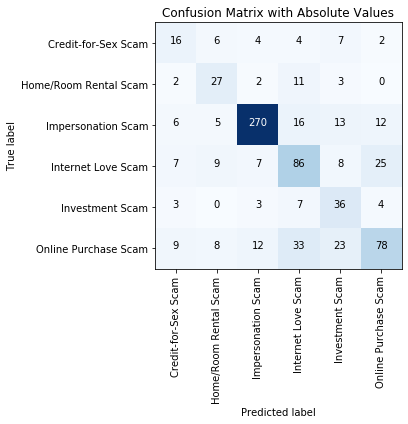

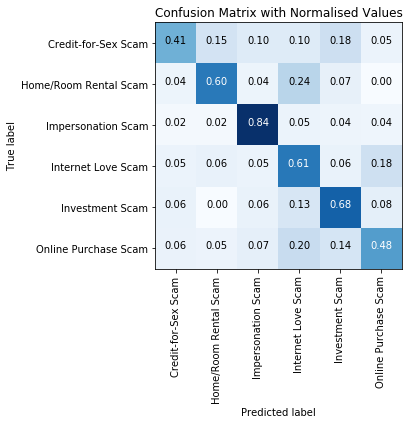

Confusion matrix saved at --> Results/Confusion_Matrix/
Normalised confusion matrix saved at --> Results/Confusion_Matrix_Normalised/

[Scam Classifier with Text Augmentation]

Loading best LSTM model from --> Models/Scam_Classifier_Augmented_Text/best-LSTM-fold-5.h5
Average Validation Accuracy: 66.7%
Accuracy on Test Set:	90.4%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.83      0.77      0.80        39
Home/Room Rental Scam       0.93      0.96      0.95        45
   Impersonation Scam       0.97      0.92      0.94       322
   Internet Love Scam       0.93      0.87      0.90       142
      Investment Scam       0.75      0.94      0.83        53
 Online Purchase Scam       0.84      0.91      0.87       163

             accuracy                           0.90       764
            macro avg       0.88      0.89      0.88       764
         weighted avg       0.91      0.90      0.91       764

Classificati

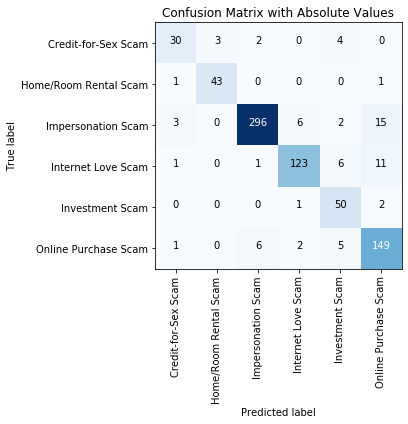

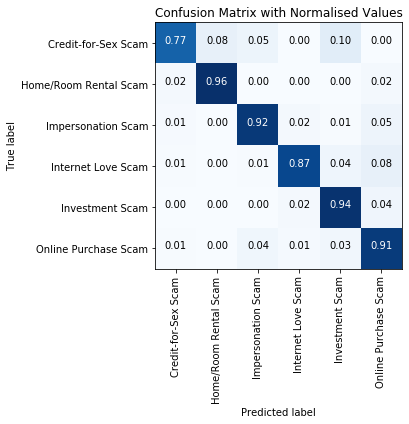

Confusion matrix saved at --> Results/Confusion_Matrix/
Normalised confusion matrix saved at --> Results/Confusion_Matrix_Normalised/

[Scam Classifier with Text Augmentation]

Loading best BiLSTM model from --> Models/Scam_Classifier_Augmented_Text/best-BiLSTM-fold-5.h5
Average Validation Accuracy: 65.7%
Accuracy on Test Set:	88.1%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.93      0.67      0.78        39
Home/Room Rental Scam       0.93      0.87      0.90        45
   Impersonation Scam       0.97      0.91      0.94       322
   Internet Love Scam       0.94      0.87      0.90       142
      Investment Scam       0.59      0.72      0.65        53
 Online Purchase Scam       0.78      0.94      0.86       163

             accuracy                           0.88       764
            macro avg       0.86      0.83      0.84       764
         weighted avg       0.89      0.88      0.88       764

Classifi

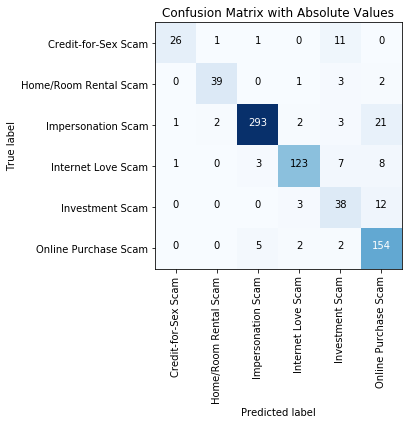

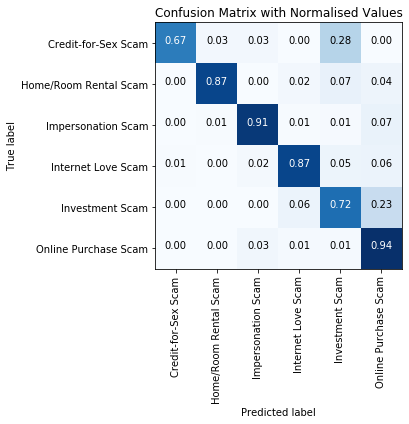

Confusion matrix saved at --> Results/Confusion_Matrix/
Normalised confusion matrix saved at --> Results/Confusion_Matrix_Normalised/

[Scam Classifier with Text Augmentation]

Loading best RNN model from --> Models/Scam_Classifier_Augmented_Text_Glove/best-RNN-fold-3.h5
Average Validation Accuracy: 34.4%
Accuracy on Test Set:	60.7%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.29      0.59      0.39        39
Home/Room Rental Scam       0.24      0.44      0.31        45
   Impersonation Scam       0.89      0.80      0.85       322
   Internet Love Scam       0.62      0.44      0.51       142
      Investment Scam       0.29      0.32      0.30        53
 Online Purchase Scam       0.55      0.51      0.53       163

             accuracy                           0.61       764
            macro avg       0.48      0.52      0.48       764
         weighted avg       0.66      0.61      0.62       764

Classifi

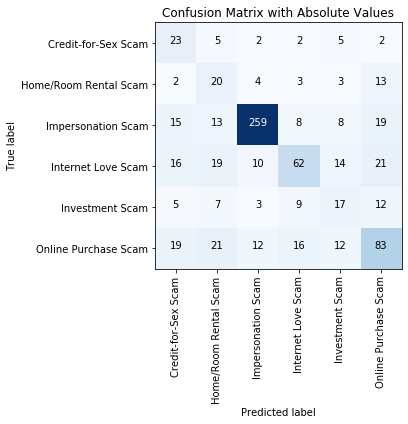

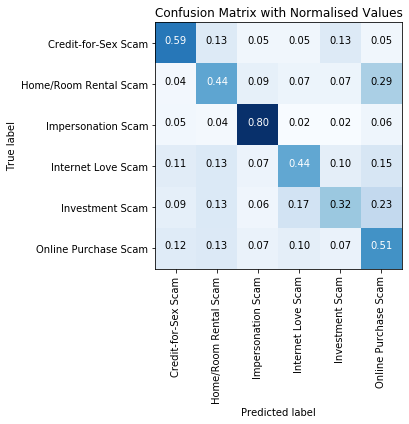

Confusion matrix saved at --> Results/Confusion_Matrix/
Normalised confusion matrix saved at --> Results/Confusion_Matrix_Normalised/

[Scam Classifier with Text Augmentation]

Loading best LSTM model from --> Models/Scam_Classifier_Augmented_Text_Glove/best-LSTM-fold-5.h5
Average Validation Accuracy: 68.4%
Accuracy on Test Set:	89.1%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.73      0.85      0.79        39
Home/Room Rental Scam       0.84      0.91      0.87        45
   Impersonation Scam       0.97      0.92      0.94       322
   Internet Love Scam       0.84      0.87      0.86       142
      Investment Scam       0.75      0.79      0.77        53
 Online Purchase Scam       0.90      0.89      0.90       163

             accuracy                           0.89       764
            macro avg       0.84      0.87      0.85       764
         weighted avg       0.90      0.89      0.89       764

Classi

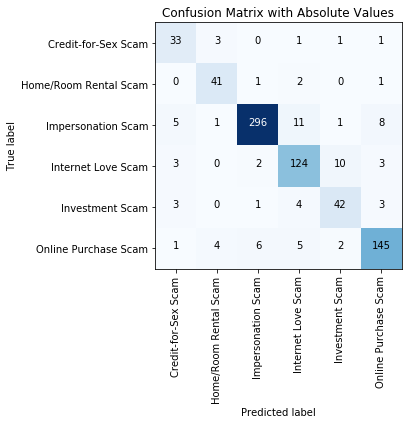

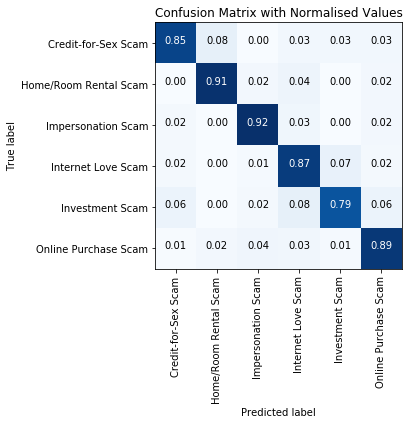

Confusion matrix saved at --> Results/Confusion_Matrix/
Normalised confusion matrix saved at --> Results/Confusion_Matrix_Normalised/

[Scam Classifier with Text Augmentation]

Loading best BiLSTM model from --> Models/Scam_Classifier_Augmented_Text_Glove/best-BiLSTM-fold-5.h5
Average Validation Accuracy: 67.2%
Accuracy on Test Set:	87.3%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.84      0.67      0.74        39
Home/Room Rental Scam       0.69      0.96      0.80        45
   Impersonation Scam       0.97      0.90      0.93       322
   Internet Love Scam       0.79      0.92      0.85       142
      Investment Scam       0.75      0.75      0.75        53
 Online Purchase Scam       0.89      0.85      0.87       163

             accuracy                           0.87       764
            macro avg       0.82      0.84      0.83       764
         weighted avg       0.88      0.87      0.87       764

Cl

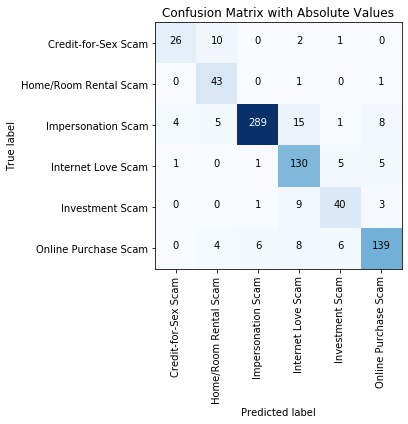

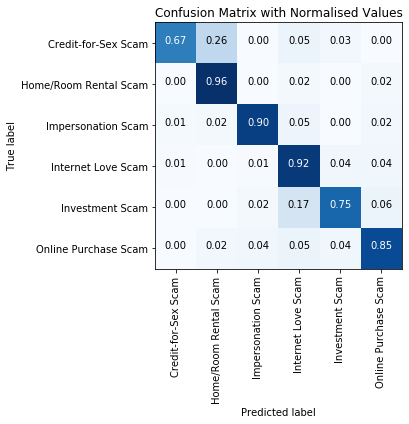

Confusion matrix saved at --> Results/Confusion_Matrix/
Normalised confusion matrix saved at --> Results/Confusion_Matrix_Normalised/

<END OF EVALUATION>


In [52]:
cat_mapping = dict(enumerate(data['scam_type'].cat.categories))
label_names = list(cat_mapping.values())
test_acc = []
print("<START OF EVALUATION>")

for i, j in results_df.iterrows():

    print("\n[Scam Classifier with Text Augmentation]\n")
  
    # Define filepath and filename to access models which gave highest validation accuracy
    filepath = "Models/" + folder_list[j['combi']-3]
    filename = "/best-" + j['model'] + "-fold-" + j['fold_max'] + ".h5"
    full_filepath = filepath + filename
    print("Loading best", j['model'], "model from -->", full_filepath)
    print("Average Validation Accuracy: %.1f%%" % j['mean_acc'])

    # Load model
    best_model = load_model(full_filepath)

    # Evaluate on the test dataset and print results
    _, acc = best_model.evaluate(X_test, to_categorical(Y_test), batch_size=16, verbose=2)
    test_acc.append(acc*100)
    print("Accuracy on Test Set:\t{0}%".format(round(acc*100,1)))
    
    # Classification report    
    pred_probabilities = best_model.predict(X_test)
    Y_pred = [np.argmax(x) for x in pred_probabilities]
    print("Classification Report:\n")
    print(classification_report(list(Y_true), Y_pred, target_names=label_names))
    
    # Save classification report as CSV file
    report = classification_report(list(Y_true), Y_pred, target_names=label_names, output_dict=True)
    filepath_cr = "Results/Classification_Reports/" 
    filename_cr = folder_list[j['combi']-3] + "-best-" + j['model'] + ".csv"
    cr_df = pd.DataFrame(report).transpose()
    cr_df.to_csv(filepath_cr + filename_cr)
    print("Classification report saved at -->", filepath_cr)

    # Print and save confusion matrix
    print("\nConfusion Matrix:\n")
    cm = confusion_matrix(list(Y_true), Y_pred)
    filepath_cm = "Results/Confusion_Matrix/"
    filename_cm = folder_list[j['combi']-3] + "-best-" + j['model'] + ".png"
    plot_confusion_matrix(cm, classes=label_names, path=filepath_cm + filename_cm)
    
    filepath_cm_norm = "Results/Confusion_Matrix_Normalised/"
    filename_cm_norm = folder_list[j['combi']-3] + "-best-normalised-" + j['model'] + ".png"
    plot_confusion_matrix(cm, normalize=True, classes=label_names, path=filepath_cm_norm + filename_cm_norm)
    print("Confusion matrix saved at -->", filepath_cm)
    print("Normalised confusion matrix saved at -->", filepath_cm_norm)

print("\n<END OF EVALUATION>")

In [53]:
# Reset index
results_df = results_df.reset_index().drop(columns='index')

# Initialise new column to store test accuracy
results_df = results_df.assign(test_acc="")

# Loop through the dataset to extract scammer name and contract from the scammer_details column
for idx, row in results_df.iterrows():
    results_df.loc[idx, 'test_acc'] = round(test_acc[idx], 1)

results_df

,model,combi,mode,glove,fold_max,mean_acc,time,test_acc
0,RNN,3,2,N,5,27.3,712.0,67.1
1,LSTM,3,2,N,5,66.7,1557.0,90.4
2,BiLSTM,3,2,N,5,65.7,2825.0,88.1
3,RNN,4,2,Y,3,34.4,538.0,60.7
4,LSTM,4,2,Y,5,68.4,1644.0,89.1
5,BiLSTM,4,2,Y,5,67.2,2903.0,87.3


## Save all results as a CSV file

In [54]:
results_df.to_csv("Results/scam_classification_results_augmented_text.csv")